In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip uninstall qiskit
!pip install qiskit==0.23.0
#!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install pylatexenc

     |████████████████████████████████| 8.5 MB 4.8 MB/s 
     |████████████████████████████████| 17.5 MB 124 kB/s 
     |████████████████████████████████| 194 kB 70.4 MB/s 
     |████████████████████████████████| 203 kB 44.2 MB/s 
     |████████████████████████████████| 2.1 MB 47.5 MB/s 
     |████████████████████████████████| 200 kB 52.0 MB/s 
     |████████████████████████████████| 1.4 MB 30.6 MB/s 
     |████████████████████████████████| 635 kB 47.1 MB/s 
     |████████████████████████████████| 108 kB 56.4 MB/s 
     |████████████████████████████████| 49 kB 4.2 MB/s 
     |████████████████████████████████| 3.0 MB 40.6 MB/s 
     |████████████████████████████████| 6.3 MB 39.0 MB/s 
  Created wheel for qiskit: filename=qiskit-0.23.0-py3-none-any.whl size=2864 sha256=9ceb099bf30aa4ac0c5e1932313865fb71250aa2af45644321d73fbf991fd5f8
  Stored in directory: /root/.cache/pip/wheels/cd/a7/06/813f3eb5ce09179e18fb91ddf5001bca795e9e20f1521394ab
  Created wheel for python-constraint: filename=py

In [3]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on the GPU")
else:
  device = torch.device("cpu")
  print("Running on the CPU")

Running on the CPU


In [4]:
#np.random.seed = 314

NUM_QUBITS = 4
NUM_SHOTS = 800 #3000
SHIFT = np.pi/4
LEARNING_RATE = 0.0002
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [5]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


# Circuit

In [6]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas = {k : Parameter('Theta'+str(k))for k in range(2*self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()

        #self.circuit.h(0)

        for k in range(0, 4):
          self.circuit.ry(self.thetas[k], k)

        self.circuit.cx(1, 0)
        self.circuit.cx(2, 0)
        self.circuit.cx(3, 0)
        self.circuit.cx(2, 1)
        self.circuit.cx(3, 1)
        self.circuit.cx(3, 2)

        for k in range(0, 4):
          self.circuit.ry(self.thetas[k+4], k)

        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0)/shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        #print('params = {}'.format(len(params)))
        backend = Aer.get_backend('qasm_simulator')
    
        job_sim = execute(self.circuit,
                              self.backend,
                              shots=self.shots,
                              parameter_binds = [{self.thetas[k] : params[k].item() for k in range(2*NUM_QUBITS)}])
#         
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts, self.shots, NUM_QUBITS)

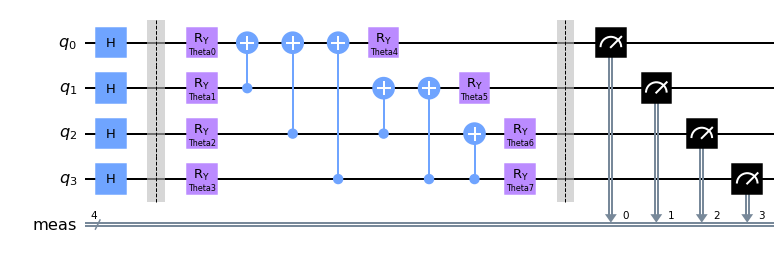

In [7]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
#print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')#, filename='Figures/{}-qubit circuit ryN.jpg'.format(NUM_QUBITS)

In [8]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value])
  
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
#         print('forward_tensor = {}'.format(forward_tensor))
        input_numbers = i
#         print('input_numbers = {}'.format(input_numbers))
        gradients = torch.Tensor()
        
        for k in range(2*NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
#             print('shift_right = {}, shift_left = {}'.format(shift_right, shift_left))
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
#             print('expectation_right = {}, \nexpectation_left = {}'.format(expectation_right, expectation_left))
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            # rescale gradient
#             gradient = gradient / torch.norm(gradient)
#             print('gradient for k={}: {}'.format(k, gradient))
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
#         print('gradients = {}'.format(result))
#         print('grad_output = {}'.format(grad_output))

        return (result.float() * grad_output.float()).T

In [9]:
import sys
sys.path.append('/content/drive/MyDrive/QAI4EO/')

In [10]:
from DatasetHandler import DatasetHandler
dataset_root = '/content/drive/MyDrive/QAI4EO/datasets/EuroSAT/EuroSAT'
handler = DatasetHandler(dataset_root)

In [11]:
classes = []
for i, c in enumerate(handler.classes):
  cl = c.split('/')[-1]
  classes.append(cl)
classes.sort()
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [12]:
imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Dataset images: 26999 Dataset labels: 26999
Dataset sample -> /content/drive/MyDrive/QAI4EO/datasets/EuroSAT/EuroSAT/PermanentCrop/PermanentCrop_2417.jpg 6


In [13]:
new_labels = []
for l in imgs_label:
  if l==0 or l==1 or l==2 or l==5 or l==6:
    new_labels.append(0)
  elif l==3 or l==4 or l==7:
    new_labels.append(1)
  elif l==8 or l==9:
    new_labels.append(2)

In [14]:
new_labels = np.array(new_labels)

In [15]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, new_labels, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5399,)   Y_val shape:  (5399,)


In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)

        #self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(2304, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 42)

        self.fc4 = nn.Linear(2304, 2*NUM_QUBITS)
        
        self.qc = TorchCircuit.apply

        self.fc5 = nn.Linear(16, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = x.view(-1, 2304)
        #x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        #x = F.relu(self.fc2(x))

        #x = F.relu(self.fc3(x))

        x = self.fc4(x)
        x = np.pi*torch.tanh(x)
        
        x = self.qc(x[0]) # QUANTUM LAYER
        
        x = F.relu(x)
        #print('output of QC = {}'.format(x))
        
#         # softmax rather than sigmoid
        x = self.fc5(x.float())
        #print('output of Linear(1, 2): {}'.format(x))
        x = F.softmax(x, 1)

        #x = torch.sigmoid(x)
        #x = torch.cat((x, 1-x), -1)
        return x
    
    
    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
#         print(pred)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net()#.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.0002)

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#from torchsummary import summary
#summary(network, (3, 64, 64))

In [18]:
train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))

In [19]:
checkpoint = torch.load('/content/drive/MyDrive/QAI4EO/model-real-amp-coarse.pt')
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
train_loss_list = []
val_loss_list = []
epochs = 25

loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
  train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader) 
    # print(batch_idx)
    optimizer.zero_grad()        
    # Forward pass
    output = network(data)
    # Calculating loss
    loss = loss_func(output, target)
    # Backward pass
    loss.backward()
    # Optimize the weights
    optimizer.step()
    
    total_loss.append(loss.item())
    
    print('\r Epoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')
    
  
  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = network(data)
      loss = loss_func(output, target)
      val_loss.append(loss.item())
      targets.append(target.item())
      predictions.append(network.predict(data).item())
   
  train_loss_list.append(sum(total_loss)/len(total_loss))
  val_loss_list.append(sum(val_loss)/len(val_loss))
  
  print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
      100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))
  
  if epoch % 3 == 1:
    print(confusion_matrix(targets, predictions,normalize='true'))
    print(classification_report(targets, predictions, target_names=['Vegetation','Buildings', 'Water Bodies'], digits=4))
    torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/content/drive/MyDrive/QAI4EO/model-real-amp-coarse.pt')
    #torch.save(network.state_dict(), '/content/drive/MyDrive/QAI4EO/model-bell.pt')

In [ ]:
fig, plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend(['Training', 'Validation'])
plt.show()

# Save tests

In [20]:
checkpoint = torch.load('/content/drive/MyDrive/QAI4EO/model-real-amp-coarse.pt')
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [21]:
test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))

In [22]:
batch_in = np.zeros((1, 3, 64, 64))

with torch.no_grad():
  targets = []
  predictions = []
  paths = []

  for batch_idx in range(len(val_images)):
    paths.append(val_images[batch_idx])
    batch_in[0,...] = np.transpose(plt.imread(val_images[batch_idx])/255.0)

    targets.append(val_labels[batch_idx])
    
    output = network.predict(torch.Tensor(batch_in)).item()
    predictions.append(output)

    print('\r  IMG: %d of %d' % (batch_idx, len(val_images)), end='\t\t')
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  IMG: 5398 of 5399		

In [23]:
original_path = []

for path in paths:
  if 'AnnualCrop' in path:
    original_path.append(0)
  elif 'Forest' in path:
    original_path.append(1)
  elif 'HerbaceousVegetation' in path:
    original_path.append(2)
  elif 'Highway' in path:
    original_path.append(3)
  elif 'Industrial' in path:
    original_path.append(4)
  elif 'Pasture' in path:
    original_path.append(5)
  elif 'PermanentCrop' in path:
    original_path.append(6)
  elif 'Residential' in path:
    original_path.append(7)
  elif 'River' in path:
    original_path.append(8)
  elif 'SeaLake' in path:
    original_path.append(9)

In [24]:
import pandas as pd

data_dict = {'PATH': paths, 'TARGET': targets, 'FULLTARGET':original_path, 'PREDICTION':predictions}
database = pd.DataFrame.from_dict(data_dict)

In [25]:
database.head()

,PATH,TARGET,FULLTARGET,PREDICTION
0,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,2,9,2
1,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,0,0,0
2,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,2,8,2
3,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,0,1,0
4,/content/drive/MyDrive/QAI4EO/datasets/EuroSAT...,2,8,2


In [26]:
database.to_csv('/content/drive/MyDrive/QAI4EO/coarse_classification.csv')

In [27]:
print(confusion_matrix(targets, predictions,normalize='true'))
print(classification_report(targets, predictions, target_names=['Vegetation','Buildings', 'Water Bodies'], digits=4))

[[0.98704184 0.00703443 0.00592373]
 [0.01857585 0.98018576 0.00123839]
 [0.05078486 0.00461681 0.94459834]]
              precision    recall  f1-score   support

  Vegetation     0.9691    0.9870    0.9780      2701
   Buildings     0.9851    0.9802    0.9826      1615
Water Bodies     0.9827    0.9446    0.9633      1083

    accuracy                         0.9765      5399
   macro avg     0.9790    0.9706    0.9746      5399
weighted avg     0.9766    0.9765    0.9764      5399

